<a href="https://colab.research.google.com/github/BorisLoveDev/agents-of-uniform-difficulty/blob/main/mnist_param_level_calibrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
# Подключение Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Загрузка и нормализация данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Применение one-hot encoding
y_test_ohe = to_categorical(y_test, 10)
y_train_ohe = to_categorical(y_train, 10)
y_train_ohe.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 10)

In [4]:
# Загрузка данных для уровня сложности 0
x_data_level_0 = np.load('/content/drive/MyDrive/all_difficulty_data_mnist/x_data_difficult_level_0.npy')
y_data_level_0 = np.load('/content/drive/MyDrive/all_difficulty_data_mnist/y_data_difficult_level_0.npy')

# Загрузка данных для уровня сложности 6
x_data_level_6 = np.load('/content/drive/MyDrive/all_difficulty_data_mnist/x_data_difficult_level_6.npy')
y_data_level_6 = np.load('/content/drive/MyDrive/all_difficulty_data_mnist/y_data_difficult_level_6.npy')


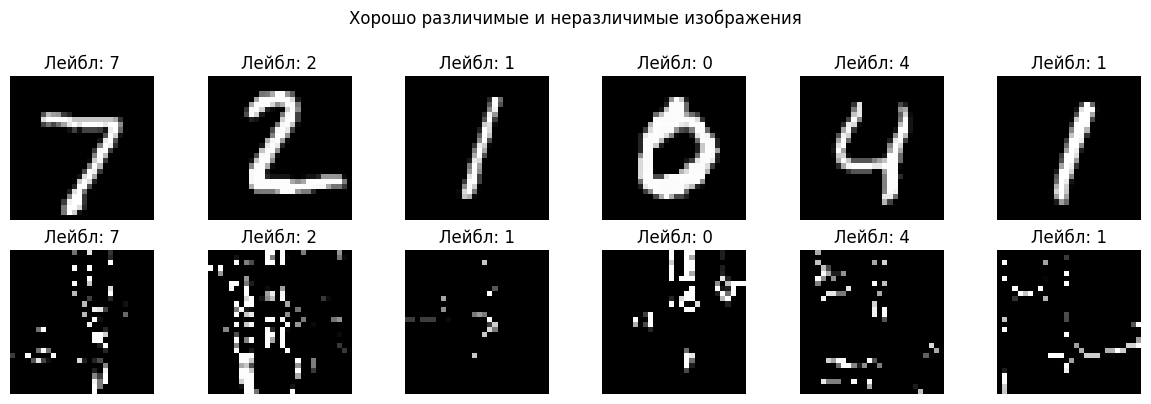

In [5]:
# Вывод 6 изображений для уровня сложности 0
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(x_data_level_0[i].reshape(28, 28), cmap='gray')
    plt.title(f"Лейбл: {y_data_level_0[i]}")
    plt.axis('off')

# Вывод 6 изображений для уровня сложности 6
for i in range(6):
    plt.subplot(2, 6, i+7)
    plt.imshow(x_data_level_6[i].reshape(28, 28), cmap='gray')
    plt.title(f"Лейбл: {y_data_level_6[i]}")
    plt.axis('off')
    plt.suptitle('Хорошо различимые и неразличимые изображения', y=1)

plt.tight_layout()
plt.show()


In [6]:
# Функция для деформации изображения, как определено ранее
def deform_image_optimized(image, A, B, M=28, NP=5):
    C = M / (NP + 1.0)
    XN, YN = np.zeros(M), np.zeros(M)
    DX, DY = np.linspace(0, M-1, M), np.linspace(0, M-1, M)

    for j in range(NP):
        TXN = (j + 0.5 - np.random.random()) * C
        TYN = (j + 0.5 - np.random.random()) * C
        TDX = (j + 0.5 - np.random.random()) * C
        TDY = (j + 0.5 - np.random.random()) * C
        AXN = B * (1.0 - 2.0 * np.random.random())
        AYN = B * (1.0 - 2.0 * np.random.random())
        ADX = A * (1.0 - 2.0 * np.random.random())
        ADY = A * (1.0 - 2.0 * np.random.random())
        PXN = (0.1 + 0.9 * np.random.random()) * C
        PYN = (0.1 + 0.9 * np.random.random()) * C
        PDX = (0.1 + 0.9 * np.random.random()) * C
        PDY = (0.1 + 0.9 * np.random.random()) * C

        DX += ADX * np.exp(-((DX - TDX) / PDX)**2)
        DY += ADY * np.exp(-((DY - TDY) / PDY)**2)
        XN += AXN * np.exp(-((DX - TXN) / PXN)**2)
        YN += AYN * np.exp(-((DY - TYN) / PYN)**2)

    deformed_image = np.zeros((M, M))
    for j in range(M):
        for i in range(M):
            x_index = int(DX[i] + XN[j])
            y_index = int(DY[j] + YN[i])
            if 0 <= x_index < M and 0 <= y_index < M:
                deformed_image[j, i] = image[y_index, x_index] if y_index < image.shape[0] and x_index < image.shape[1] else 0

    return deformed_image

In [23]:
# Параметры деформации для разных уровней сложности
# deform_params = {
#     "1": (0.2, 1.0),
#     "2": (0.4, 2.0),
#     "3": (0.6, 3.0),
#     "4": (0.8, 4.0),
#     "5": (1, 5.0),
# }
# c шагом 15%
# deform_params = {
#     "1": (0.45, 2.8),
#     "2": (0.6, 3.8),
#     "3": (0.75, 4.9),
#     "4": (0.9, 5.9),
#     "5": (2, 8),
# }

# By V.I.

# Диапазоны по вероятностям
# 1.000 - 0.996 - идеальные + 0
# 0.996-0.963 - очень лёгкие + 1
# 0.963-0.742 - лёгкие + 2
# 0.740-0.260  - средние + 3
# 0.2-0-0.037 - трудные + 4
# 0.037-0.004 - очень трудные - 5 не получается сделать меньше 10%
# 0.004-0.000 - неразличимые 6

deform_params = {
    "1": (0.2, 1.0),
    "2": (0.4, 3.0),
    "3": (1, 5.0),
    "4": (3.5, 9.5),
    "5": (5, 15),
}

In [8]:

# Создание каллибровочной сети
model2 = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение model2 на тренировочных данных
model2.fit(x_train, y_train_ohe, epochs=10, batch_size=128, validation_split=0.1, verbose=1)


Epoch 1/10
422/422 [==============================] - 9s 10ms/step - loss: 0.2274 - accuracy: 0.9299 - val_loss: 0.0440 - val_accuracy: 0.9870
Epoch 2/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0693 - accuracy: 0.9790 - val_loss: 0.0343 - val_accuracy: 0.9898
Epoch 3/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0511 - accuracy: 0.9842 - val_loss: 0.0321 - val_accuracy: 0.9912
Epoch 4/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0419 - accuracy: 0.9864 - val_loss: 0.0288 - val_accuracy: 0.9923
Epoch 5/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0339 - accuracy: 0.9893 - val_loss: 0.0308 - val_accuracy: 0.9923
Epoch 6/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0298 - accuracy: 0.9907 - val_loss: 0.0313 - val_accuracy: 0.9917
Epoch 7/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0251 - accuracy: 0.9912 - val_loss: 0.0325 - val_accuracy: 0.9908
Epoch

In [9]:
# Сначала необходимо преобразовать x_test к формату, совместимому с моделью
x_test_reshaped = x_test.reshape(-1, 28, 28, 1)

# Оценка точности на тестовом наборе
loss, accuracy = model2.evaluate(x_test_reshaped, y_test_ohe, verbose=0)
print(f"Точность на тестовых данных: {accuracy*100:.2f}%")

Точность на тестовых данных: 99.16%


In [10]:
def test_and_show_deformed_images(x_test, y_test_ohe, model, level, deform_params):
    """
    Деформирует тестовые данные на заданном уровне, отображает первые 6 деформированных изображений,
    и оценивает модель на этих данных.

    Parameters:
    - x_test: np.array, исходные тестовые данные.
    - y_test_ohe: np.array, метки классов в формате one-hot encoding.
    - model: обученная модель Keras.
    - level: str, уровень деформации, ключ в словаре deform_params.
    - deform_params: dict, словарь с параметрами деформации для каждого уровня.
    """

    if level not in deform_params:
        print(f"Уровень деформации {level} не найден.")
        return

    # Извлечение параметров деформации для заданного уровня
    A, B = deform_params[level]

    # Создание деформированных данных для заданного уровня
    deformed_images = np.array([deform_image_optimized(image.reshape(28, 28), A, B) for image in x_test]).reshape(-1, 28, 28, 1)

    # Оценка точности модели на деформированных данных
    loss, accuracy = model.evaluate(deformed_images, y_test_ohe, verbose=0)
    print(f"Точность на уровне деформации {level}: {accuracy*100:.2f}%")

    # Вывод первых 6 деформированных изображений
    plt.figure(figsize=(10, 2))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(deformed_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Лейбл: {y_test[i]}")
        plt.axis('off')
    plt.suptitle(f'Первые 6 деформированных изображений на уровне {level}')
    plt.show()

Точность на уровне деформации 5: 14.04%


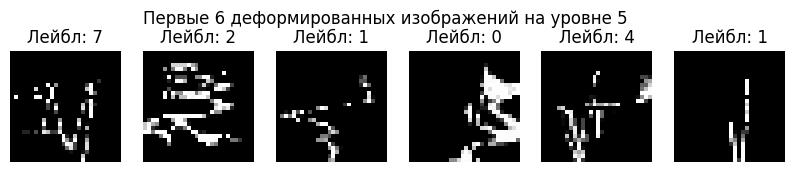

In [25]:
# Пример использования функции для уровня деформации
test_and_show_deformed_images(x_test_reshaped, y_test_ohe, model2, '5', deform_params)

In [12]:
def generate_deformed_data(x_data, deform_params):
    # Создание словаря для хранения деформированных данных по уровням сложности
    deformed_data = {}
    for level, params in deform_params.items():
        A, B = params
        # Деформация всех тестовых изображений согласно текущим параметрам деформации
        deformed_images = np.array([deform_image_optimized(image.reshape(28, 28), A, B) for image in x_data]).reshape(-1, 28, 28, 1)
        deformed_data[level] = deformed_images
    return deformed_data

# Генерация деформированных тестовых данных для каждого уровня сложности
deformed_test_data = generate_deformed_data(x_test, deform_params)


KeyboardInterrupt: 

In [ ]:
for level, data in deformed_test_data.items():
    # Оценка точности модели на деформированных данных для текущего уровня сложности
    loss, accuracy = model2.evaluate(data, y_test_ohe, verbose=0)
    print(f"Точность на уровне деформации {level}: {accuracy*100:.2f}%")


Точность на уровне деформации 1: 98.35%
Точность на уровне деформации 2: 94.64%
Точность на уровне деформации 3: 82.02%
Точность на уровне деформации 4: 65.83%
Точность на уровне деформации 5: 50.60%
